# A numerical variability approach to results stability tests and its application to neuroimaging

This Jupyter notebook reproduces figures present in the paper.

In [383]:
%pip install nibabel
%pip install nilearn
%pip install matplotlib
%pip install plotly
%pip install kaleido
%pip install xarray


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note

In [384]:
import glob
import os

import nibabel
import nilearn.masking
import numpy as np
import pandas as pd
import significantdigits as sdg
import tqdm
from joblib import Parallel, delayed
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nilearn.plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Image

## Table II. Dimensions, voxels resolutions, age and sex of each subject in the dataset.

In [385]:
data = {
    "Index": [1, 2, 3, 4, 5, 6, 7, 8],
    "Dataset": [
        "ds000256",
        "ds000256",
        "ds001600",
        "ds001748",
        "ds001748",
        "ds001771",
        "ds002338",
        "ds002338",
    ],
    "Subject": [
        "sub-CTS201",
        "sub-CTS210",
        "sub-1",
        "sub-adult15",
        "sub-adult16",
        "sub-36",
        "sub-xp201",
        "sub-xp207",
    ],
    "Dimension (x, y, z)": [
        "256 × 256 × 256",
        "224 × 256 × 256",
        "176 × 256 × 256",
        "176 × 240 × 256",
        "176 × 240 × 256",
        "256 × 320 × 320",
        "176 × 512 × 512",
        "176 × 512 × 512",
    ],
    "Voxel resolution (x, y, z)": [
        "1.0 × 1.0 × 1.0",
        "0.8 × 0.8 × 0.8",
        "1.0 × 1.0 × 1.0",
        "1.0 × 1.0 × 1.0",
        "1.0 × 1.0 × 1.0",
        "0.8 × 0.8 × 0.8",
        "1.0 × 0.5 × 0.5",
        "1.0 × 0.5 × 0.5",
    ],
    "Data type": [
        "int16",
        "int16",
        "int16",
        "float32",
        "float32",
        "int16",
        "int16",
        "int16",
    ],
    "Age (years)": [8.68, 7.63, "-", 21, 21, 22, 41, 39],
    "Sex": ["M", "F", "-", "M", "F", "F", "F", "M"],
}

subjects_table = pd.DataFrame(data)

def get_index(dataset, subject):
    return subjects_table[
        (subjects_table["Dataset"] == dataset) & (subjects_table["Subject"] == subject)
    ]["Index"].values[0]

def get_dataset_subject(index):
    return subjects_table[subjects_table["Index"] == index][["Dataset", "Subject"]].values[0]

subjects_table

Index   Dataset      Subject Dimension (x, y, z)  \
0      1  ds000256   sub-CTS201     256 × 256 × 256   
1      2  ds000256   sub-CTS210     224 × 256 × 256   
2      3  ds001600        sub-1     176 × 256 × 256   
3      4  ds001748  sub-adult15     176 × 240 × 256   
4      5  ds001748  sub-adult16     176 × 240 × 256   
5      6  ds001771       sub-36     256 × 320 × 320   
6      7  ds002338    sub-xp201     176 × 512 × 512   
7      8  ds002338    sub-xp207     176 × 512 × 512   

  Voxel resolution (x, y, z) Data type Age (years) Sex  
0            1.0 × 1.0 × 1.0     int16        8.68   M  
1            0.8 × 0.8 × 0.8     int16        7.63   F  
2            1.0 × 1.0 × 1.0     int16           -   -  
3            1.0 × 1.0 × 1.0   float32          21   M  
4            1.0 × 1.0 × 1.0   float32          21   F  
5            0.8 × 0.8 × 0.8     int16          22   F  
6            1.0 × 0.5 × 0.5     int16          41   F  
7            1.0 × 0.5 × 0.5     int16          39   M

In [386]:
# Constants 

project_root = "numerical-variability-data"
fmriprep_results = os.path.join(project_root, "fmriprep-fuzzylibm-results")
fmriprep_reference_version = "20.2.1"
significant_digits_path = os.path.join(project_root, "significant-digits", "osfstorage")
stability_test_results = os.path.join(project_root, "osfstorage", "stability-test-results")
perturbations = ["rr", "rs"]
FWHM_min = 0
FWHM_max = 20
FWHMs = list(range(FWHM_min, FWHM_max + 1))
colorblind_palette = ["#D55E00", "#009E73"]

# Set to true for interactive plots
dynamic_figure = False


In [387]:
# Compute significant digits for each perturbation, subject and FWHM


def load_T1w(directory, dataset, subject):
    t1 = f"{subject}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
    path = os.path.join(directory, '**', f"*{dataset}*", "**", "anat", t1)
    return glob.glob(path, recursive=True)


def load_brain_mask(directory, dataset, subject):
    mask = f"{subject}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    path = os.path.join(directory, '**', f"*{dataset}*", "**", "anat", mask)
    return glob.glob(path, recursive=True)


def compute_brain_mask_union(brain_masks):
    UNION = 0
    mask_union = nilearn.masking.intersect_masks(brain_masks, threshold=UNION)
    return mask_union


def apply_mask(t1ws, mask_union, smoothing_fwhm=None):
    import nilearn.masking

    if smoothing_fwhm == 0:
        smoothing_fwhm = None
    t1w_preproc = np.fromiter(
        (
            nilearn.masking.apply_mask(t1w, mask_union, smoothing_fwhm=smoothing_fwhm)
            for t1w in t1ws
        ),
        dtype=np.dtype((np.float32, np.count_nonzero(mask_union.get_fdata()))),
    )
    return t1w_preproc


def get_sig_output_path(cache, perturbation, index, fwhm, normalized):
    normalized = "normalized" if normalized else "unnormalized"
    return os.path.join(
        cache, normalized, perturbation, f"{perturbation}-Subject-{index}_FWHM-{fwhm}.npz"
    )

def compute_significant_digits_unnormalized(voxels, mask_union, output_normalized):
    reference = np.mean(voxels, axis=0)
    sig = sdg.significant_digits(voxels, reference=reference)
    np.savez_compressed(output_normalized, sig=sig, mask=mask_union)


def compute_significant_digits_normalized(voxels, mask_union, output_unnormalized):
    iterator = ((v - v.min()) / (v.max() - v.min()) for v in voxels)
    voxels = np.fromiter(iter=iterator, dtype=np.dtype((np.float32, voxels.shape[1:])))
    reference = np.mean(voxels, axis=0)
    sig = sdg.significant_digits(voxels, reference=reference)
    np.savez_compressed(output_unnormalized, sig=sig, mask=mask_union)


def compute_significant_digits(
    t1ws, mask_union, fwhm, perturbation, index, cache, force=False
):
    output_normalized = get_sig_output_path(cache, perturbation, index, fwhm, True)
    output_unnormalized = get_sig_output_path(cache, perturbation, index, fwhm, False)
    voxels = apply_mask(t1ws, mask_union, fwhm)
    if not os.path.exists(output_normalized) or force:
        compute_significant_digits_normalized(voxels, mask_union, output_normalized)
    if not os.path.exists(output_unnormalized) or force:
        compute_significant_digits_unnormalized(voxels, mask_union, output_unnormalized)

def get_FWHM_to_compute(cache, perturbation, index):
    fwhms = []
    for i in FWHMs:
        output_normalized = get_sig_output_path(significant_digits_path, perturbation, index, i, True)
        output_unnormalized = get_sig_output_path(significant_digits_path, perturbation, index, i, False)
        if not os.path.exists(output_normalized) or not os.path.exists(output_unnormalized):
            fwhms.append(i)
    return fwhms

def create_directories(cache, perturbation):
    normalized_path = get_sig_output_path(cache, perturbation, 0, 0, True)
    unnormalized_path = get_sig_output_path(cache, perturbation, 0, 0, False)
    os.makedirs(os.path.dirname(normalized_path), exist_ok=True)
    os.makedirs(os.path.dirname(unnormalized_path), exist_ok=True)
    os.makedirs(cache, exist_ok=True)


for perturbation in perturbations:
    create_directories(significant_digits_path, perturbation)

    for index in subjects_table["Index"]:
        directory = os.path.join(fmriprep_results, fmriprep_reference_version, perturbation)
        # only recompute missing significant digits for given FWHMs
        fwhms = get_FWHM_to_compute(significant_digits_path, perturbation, index)
        if len(fwhms) == 0:
            continue
        
        dataset, subject = get_dataset_subject(index)        
        t1ws = load_T1w(directory, dataset, subject)
        brain_masks = load_brain_mask(directory, dataset, subject)
        mask_union = compute_brain_mask_union(brain_masks)

        def producer():
            for fwhm in fwhms:
                yield (
                    t1ws,
                    mask_union,
                    fwhm,
                    perturbation,
                    index,
                    significant_digits_path,
                )

        # Adjust n_jobs according to ressources available
        Parallel(n_jobs=32)(
            delayed(compute_significant_digits)(*args)
            for args in tqdm.tqdm(producer(), unit="FWHM")
        )

In [388]:
def compute_sig_mean(perturbation, index, fwhm, normalized=True):
    normalized = "normalized" if normalized else "unnormalized"
    npz = get_sig_output_path(significant_digits_path, perturbation, index, fwhm, normalized)
    data = np.load(npz)
    sig = data["sig"]
    return np.mean(sig)

def run(perturbation, normalized):
    sig = {
        index: Parallel(n_jobs=21)(
            delayed(compute_sig_mean)(perturbation, index, i, normalized=normalized)
            for i in range(0, 21)
        )
        for index in subjects_table["Index"]
    }
    sig = (
        pd.DataFrame.from_dict(sig)
        .unstack()
        .reset_index()
        .rename(columns={"level_0": "Index", "level_1": "FWHM", 0: "Significant bits"})
    )
    sig["Perturbation"] = perturbation
    return sig


significant_digits_normalized = pd.concat([run("rr",True), run("rs",True)])
significant_digits_unnormalized = pd.concat([run("rr",False), run("rs",False)])


In [389]:
def unmask(perturbation, index, fwhm, normalized=True):
    normalized = "normalized" if normalized else "unnormalized"
    npz = get_sig_output_path(significant_digits_path, perturbation, index, fwhm, normalized)
    data = np.load(npz, allow_pickle=True)
    sig, mask_union = data["sig"], data["mask"]
    return nilearn.masking.unmask(sig, mask_union.item())


def view_significant_digits_brain(
    perturbation,
    index,
    fwhm,
    title=None,
    vmax=12,
    vmin=0,
    discrete=False,
    normalized=True,
):
    cmap = plt.colormaps.get_cmap("RdYlGn")
    cmap = cmap.resampled(np.abs(vmax - vmin)) if discrete else cmap
    sig_img = unmask(perturbation, index, fwhm, normalized=normalized)
    voxels = sig_img.get_fdata()
    sig_img_thresholded = nibabel.Nifti1Image(
        np.where(voxels <= 0, 0, voxels), sig_img.affine
    )
    return nilearn.plotting.view_img(
        sig_img_thresholded,
        cmap=cmap,
        symmetric_cmap=False,
        black_bg=True,
        vmin=vmin,
        vmax=vmax,
        bg_img=None,
        cut_coords=(0, 0, 0),
        title=title,
    )


def get_figure_path(directory, perturbation, index, fwhm):
    perturbation += '-' if perturbation else ''
    return os.path.join(
        significant_digits_path,
        "figures",
        directory,
        f"{perturbation}Subject-{index}_FWHM-{fwhm}.png",
    )
    

def plot_ieee_brain(index, fwhm):
    output_path = get_figure_path("ieee", "", index, fwhm)
    if os.path.exists(output_path):
        return
    fwhm = None if fwhm == 0 else fwhm
    # Load T1w and apply brain mask
    directory = os.path.join(fmriprep_results, fmriprep_reference_version, "ieee", "osfstorage")
    dataset, subject = get_dataset_subject(index)
    t1w = load_T1w(directory, dataset, subject)[0]
    brain_mask = load_brain_mask(directory, dataset, subject)[0]
    voxel = nilearn.masking.apply_mask(t1w, brain_mask, smoothing_fwhm=fwhm)
    t1w_masked = nilearn.masking.unmask(voxel, brain_mask)
    return nilearn.plotting.plot_anat(
        t1w_masked,
        output_file=output_path,
        cut_coords=(0, 0, 0),
        draw_cross=False,
        black_bg=True,
        bg_img=None,
    )


def plot_significant_digits_brain(
    perturbation,
    index,
    fwhm,
    title=None,
    vmax=12,
    vmin=0,
    discrete=True,
    normalized=True,
):
    directory = "normalized" if normalized else "unnormalized"
    output_path = get_figure_path(directory, perturbation, index, fwhm)
    if os.path.exists(output_path):
        return

    cmap = plt.colormaps.get_cmap("RdYlGn")
    cmap = cmap.resampled(np.abs(vmax - vmin)) if discrete else cmap
    sig_img = unmask(perturbation, index, fwhm, normalized=normalized)
    voxels = sig_img.get_fdata()
    # Remove negative significant digits
    sig_img_thresholded = nibabel.Nifti1Image(
        np.where(voxels <= 0, 0, voxels), sig_img.affine
    )

    return nilearn.plotting.plot_anat(
        sig_img_thresholded,
        cmap=cmap,
        black_bg=True,
        threshold=0.01,
        vmin=vmin,
        vmax=vmax,
        bg_img=None,
        cut_coords=(0, 0, 0),
        draw_cross=False,
        title=title,
        output_file=output_path,
    )


def ieee_producer():
    for index in subjects_table["Index"]:
        for fwhm in FWHMs:
            yield (index, fwhm)

def producer():
    for perturbation in perturbations:
        for index in subjects_table["Index"]:
            for fwhm in FWHMs:
                yield (perturbation, index, fwhm)

Parallel(n_jobs=16)(delayed(plot_ieee_brain)(*args) for args in tqdm.tqdm(ieee_producer(), unit="image"))

Parallel(n_jobs=16)(
    delayed(plot_significant_digits_brain)(*args, discrete=True, normalized=False)
    for args in tqdm.tqdm(producer(), unit="image")
)
none=Parallel(n_jobs=16)(
    delayed(plot_significant_digits_brain)(*args, discrete=True, normalized=True)
    for args in tqdm.tqdm(producer(), unit="image")
)

0image [00:00, ?image/s]

168image [00:12, 12.97image/s]
336image [00:00, 955.97image/s]
336image [00:00, 989.68image/s]


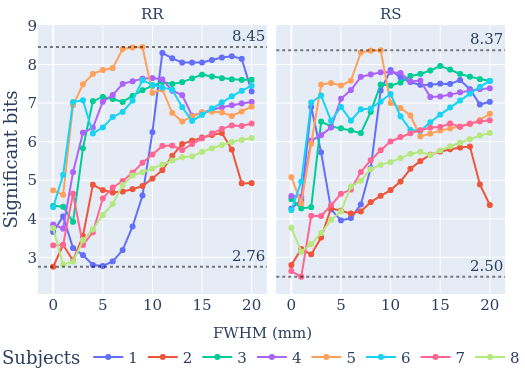

In [390]:

def plot_significant_digits(sig_data, title):
    sig_min = min(min(v) for v in sig_data.values())
    sig_max = max(max(v) for v in sig_data.values())
    fig = px.line(sig_data, markers=True, title=title)
    fig.update_xaxes(title="FWHM (mm)")
    fig.update_yaxes(title="Significant bits")
    fig.update_legends(title="Subjects")
    fig.add_hline(
        y=sig_min,
        line_dash="dot",
        line_color="black",
        opacity=0.5,
        annotation_text=f"{sig_min:.2f}",
    )
    fig.add_hline(
        y=sig_max,
        line_dash="dot",
        line_color="black",
        opacity=0.5,
        annotation_text=f"{sig_max:.2f}",
    )
    return fig

def plot_dot_line(fig, y, col):
    fig.add_hline(
        y=y,
        line_dash="dot",
        line_color="black",
        opacity=0.5,
        annotation_text=f"{y:.2f}",
        row=1,
        col=col,
    )


def plot_sig(sig):

    fig = px.line(sig, markers=True, x="FWHM", y="Significant bits", color="Index", facet_col="Perturbation", title="FWHM (mm)")
    fig.update_layout(font_family="Serif")
    fig.update_legends(orientation='h', yanchor="bottom", y=-.30, xanchor="center", x=0.5, bgcolor='rgba(0,0,0,0)', title="Subjects")
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].upper()))

    stats = sig.groupby("Perturbation").describe()
    for col, perturbation in enumerate(perturbations, start=1):
        plot_dot_line(fig, stats["Significant bits"]["min"][perturbation], col)
        plot_dot_line(fig, stats["Significant bits"]["max"][perturbation], col)

    fig.update_layout(
        width=525,
        height=375,
        title={
            "xanchor": "center",
            "x": 0.5,
            "font_size": 15,
        },
    )
    
    fig.update_xaxes(title="")
    fig.update_layout(title_y=0.1,
                      margin=dict(l=0, r=20, t=25, b=80),
                      legend_xref="paper",
                      legend_yref="paper",
                      font=dict(size=15))
    fig.update_layout(showlegend=True)
    fig.write_image("significant_digits.png", scale=4)
    return fig


fig = plot_sig(significant_digits_normalized)
if dynamic_figure:
    img = fig.show()
else:
    img = Image(fig.to_image(format="png"))
img

### Figure 2: Voxel-wise means of significant bits measured across n=30 perturbed samples for RR and RS perturbations and 8 subjects.

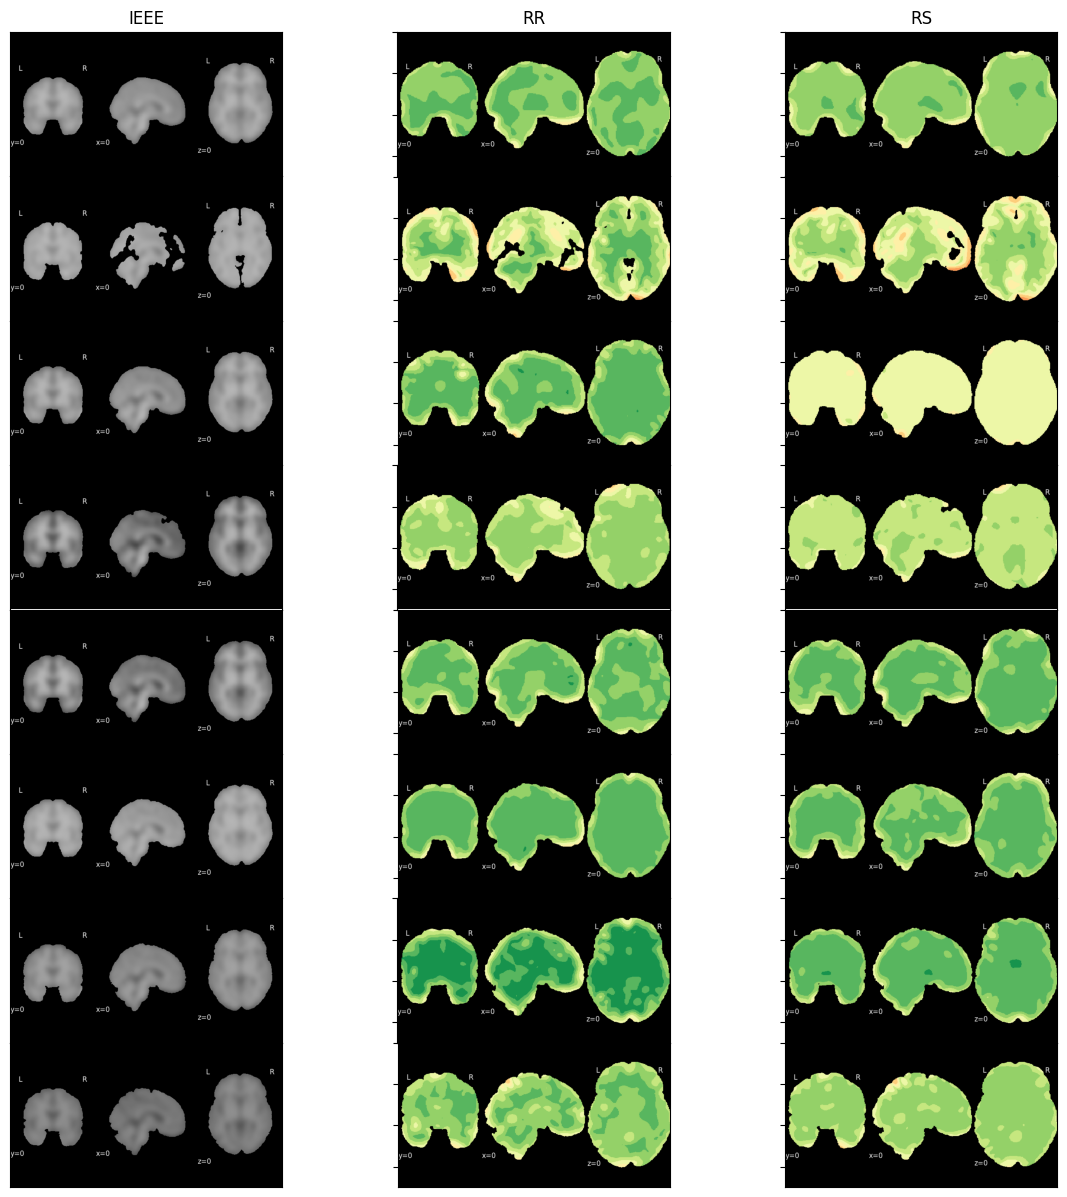

In [391]:
import matplotlib.pyplot as plt


def create_grid_numerical_variability(normalized, fwhm):
    plt.close()
    is_normalized = "normalized" if normalized else "unnormalized"

    f, axarr = plt.subplots(
        8,
        3,
        figsize=(15, 15),
        sharex=True,
        sharey=True,
        gridspec_kw={"hspace": 0, "wspace": 0},
    )

    for row, index in enumerate(subjects_table["Index"], start=1):
        ieee_filename = get_figure_path("ieee", "", index, fwhm)
        rr_filename = get_figure_path(is_normalized, "rr", index, fwhm)
        rs_filename = get_figure_path(is_normalized, "rs", index, fwhm)

        ieee_img = plt.imread(ieee_filename)
        rr_img = plt.imread(rr_filename)
        rs_img = plt.imread(rs_filename)

        axarr[row - 1, 0].set_title(f"IEEE")
        axarr[row - 1, 0].tick_params(
            axis="x", bottom=False, labelbottom=False, top=False, labeltop=False
        )
        axarr[row - 1, 0].tick_params(
            axis="y", right=False, labelright=False, left=False, labelleft=False
        )
        axarr[row - 1, 1].set_title(f"RR")
        axarr[row - 1, 1].tick_params(
            axis="x", bottom=False, labelbottom=False, top=False, labeltop=False
        )
        axarr[row - 1, 2].set_title(f"RS")
        axarr[row - 1, 2].tick_params(
            axis="x", bottom=False, labelbottom=False, top=False, labeltop=False
        )

        axarr[row - 1, 0].imshow(ieee_img)
        axarr[row - 1, 1].imshow(rr_img)
        axarr[row - 1, 2].imshow(rs_img)

    plt.subplots_adjust(wspace=0, hspace=0)
    
create_grid_numerical_variability(normalized=False, fwhm=15)

## Figure 3: Numerical variability measured for subjects 1 to 8 (from top to bottom) across n=30 perturbed samples, with FWHM = 15 mm.

In [392]:
def load_pickle_files(files):
    """
    Load all pickle files in a directory
    """
    df = pd.concat(pd.DataFrame(pd.read_pickle(file)) for file in files)
    return df

In [393]:
from scipy.stats import binomtest

loo_pickles = os.path.join(stability_test_results, "loo", "*.pkl")
loo_experiments = glob.glob(loo_pickles, recursive=True)
loo_df = load_pickle_files(loo_experiments)
loo_df.groupby(
    [
        "reference_version",
        "reference_dataset",
        "reference_subject",
        "reference_perturbation",
        "reference_template",
        "reference_fwhm",
        "target_dataset",
        "target_subject",
        "target_template",
        "confidence",
    ],
    group_keys=True,
).apply(lambda x: x, include_groups=False)
loo_bonferroni = loo_df[loo_df["method"] == "fwe-bonferroni"].copy()

# A test pass if none of the voxels are rejected
loo_bonferroni.loc[:, "pass"] = loo_bonferroni["reject"] < 1
loo_bonferroni.loc[:, "alpha"] = 1 - loo_bonferroni["confidence"]
loo_bonferroni = pd.merge(
    loo_bonferroni,
    subjects_table[["Index", "Dataset", "Subject"]],
    left_on="target_subject",
    right_on="Subject",
)
# Compute how many rounds passed the test
loo_bonferroni = loo_bonferroni.groupby(
    [
        "reference_dataset",
        "reference_subject",
        "reference_perturbation",
        "reference_template",
        "reference_fwhm",
        "target_dataset",
        "target_subject",
        "target_template",
        "confidence",
        "nb_round",
        "Index",
        "alpha",
    ]
)["pass"].sum()
loo_bonferroni = loo_bonferroni.reset_index()

# Each test performed a Bonferroni test with a confidence level c
# By performing N tests, we expect N * c tests to pass
# The binomial test tests with a confidence 0.95 if we are not below N * c 
def binom_test(x):
    return (
        binomtest(
            k=x["pass"], n=x["nb_round"], p=x["confidence"], alternative="less"
        ).pvalue
        > 0.05
    )


loo_bonferroni["binomial_test"] = loo_bonferroni.apply(binom_test, axis=1)
loo_bonferroni

reference_dataset reference_subject reference_perturbation  \
0             ds000256        sub-CTS201                     rr   
1             ds000256        sub-CTS201                     rr   
2             ds000256        sub-CTS201                     rr   
3             ds000256        sub-CTS201                     rr   
4             ds000256        sub-CTS201                     rr   
...                ...               ...                    ...   
4363          ds002338         sub-xp207                     rs   
4364          ds002338         sub-xp207                     rs   
4365          ds002338         sub-xp207                     rs   
4366          ds002338         sub-xp207                     rs   
4367          ds002338         sub-xp207                     rs   

       reference_template  reference_fwhm target_dataset target_subject  \
0     MNI152NLin2009cAsym               0       ds000256     sub-CTS201   
1     MNI152NLin2009cAsym               0       ds000256     sub-CTS201   
2     MNI152NLin2009cAsym               0       ds000256     sub-CTS201   
3     MNI152NLin2009cAsym               0       ds000256     sub-CTS201   
4     MNI152NLin2009cAsym               0       ds000256     sub-CTS201   
...                   ...             ...            ...            ...   
4363  MNI152NLin2009cAsym              20       ds002338      sub-xp207   
4364  MNI152NLin2009cAsym              20       ds002338      sub-xp207   
4365  MNI152NLin2009cAsym              20       ds002338      sub-xp207   
4366  MNI152NLin2009cAsym              20       ds002338      sub-xp207   
4367  MNI152NLin2009cAsym              20       ds002338      sub-xp207   

          target_template  confidence  nb_round  Index  alpha  pass  \
0     MNI152NLin2009cAsym       0.500        30      1  0.500     0   
1     MNI152NLin2009cAsym       0.550        30      1  0.450     0   
2     MNI152NLin2009cAsym       0.600        30      1  0.400     0   
3     MNI152NLin2009cAsym       0.650        30      1  0.350     0   
4     MNI152NLin2009cAsym       0.700        30      1  0.300     0   
...                   ...         ...       ...    ...    ...   ...   
4363  MNI152NLin2009cAsym       0.900        30      8  0.100    29   
4364  MNI152NLin2009cAsym       0.950        30      8  0.050    29   
4365  MNI152NLin2009cAsym       0.990        30      8  0.010    29   
4366  MNI152NLin2009cAsym       0.995        30      8  0.005    29   
4367  MNI152NLin2009cAsym       0.999        30      8  0.001    29   

      binomial_test  
0             False  
1             False  
2             False  
3             False  
4             False  
...             ...  
4363           True  
4364           True  
4365           True  
4366           True  
4367          False  

[4368 rows x 14 columns]

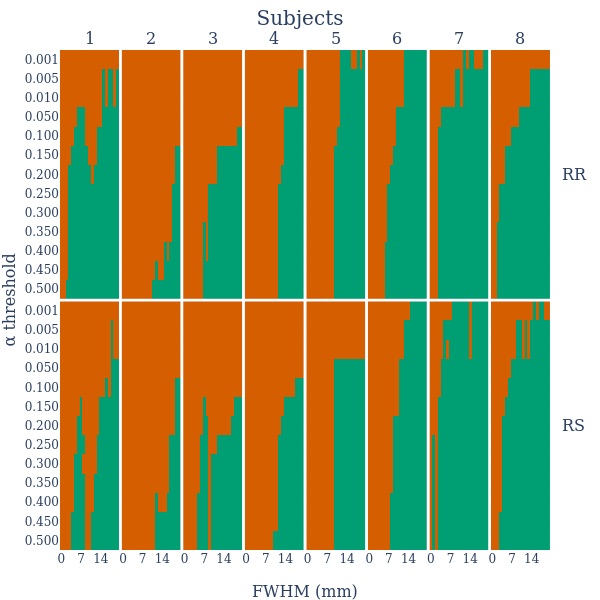

In [394]:
def rotate_row_titles(fig, row_titles):
    for annotation in fig["layout"]["annotations"]:
        if annotation["text"] in row_titles:
            annotation["textangle"] = 0
            annotation["x"] = 1
            annotation["xref"] = "paper"
            annotation["xanchor"] = "left"
            annotation["yref"] = "paper"
            annotation["yanchor"] = "middle"


def plot_loo_check(df):
    rr = df[df["reference_perturbation"] == "rr"]
    rs = df[df["reference_perturbation"] == "rs"]

    indexes = df["Index"].unique()
    indexes.sort()

    column_titles = list(map(str, indexes))
    row_titles = ["RR", "RS"]

    fig = make_subplots(
        rows=2,
        cols=indexes.size,
        column_titles=column_titles,
        row_titles=2 * row_titles,
        shared_xaxes=True,
        shared_yaxes=True,
        x_title="FWHM (mm)",
        y_title="α threshold",
        vertical_spacing=0.005,
        horizontal_spacing=0.005,
    )
    alpha = df["alpha"].unique()
    alpha.sort()
    alpha = np.flip(alpha)

    x = list(map(str, df["reference_fwhm"].unique()))
    y = [f"{alpha:.3f}" for alpha in alpha]

    dfs = [rr, rs]
    for i, df in enumerate(dfs, start=1):
        for j, index in enumerate(indexes, start=1):
            data = df[df["Index"] == index]
            z=data.pivot(columns="reference_fwhm", index="alpha", values="binomial_test").to_numpy().astype(int)
            fig.add_trace(
                go.Heatmap(
                    z=np.flip(z, axis=0),
                    x=x,
                    y=y,
                    colorscale=colorblind_palette,
                    zmin=0,
                    zmax=1,
                    showscale=False,
                ),
                row=i,
                col=j,
            )

    fig.update_xaxes(nticks=3)
    fig.update_layout(coloraxis_showscale=False)
    fig.update_traces(showlegend=False)
    fig.update_coloraxes(showscale=False)
    fig.update_layout(font_family="Serif", showlegend=False)
    rotate_row_titles(fig, row_titles)
    fig.update_layout(
        width=600,
        height=600,
        title={
            "text": "Subjects",
            "xanchor": "center",
            "x": 0.5,
            "font_size": 20,
        },
        margin=dict(l=60, r=40, t=50, b=50),
    )

    fig.write_image("loo_bonferroni.png", scale=4)
    return fig

fig = plot_loo_check(loo_bonferroni.reset_index())
if dynamic_figure:
    img = fig.show()
else:
    img = Image(fig.to_image(format="png"))
img


### Figure 4: Leave-one-out evaluation of stability test for subjects 1 to 8. Red/green: rejected/accepted by a binomial one-tailed test with sample size $n = 30$ and confidence level $1 − α_0 = 0.95$.

In [395]:
subject_pickles = os.path.join(stability_test_results, "subjects", "*.pkl")
subject_experiments = glob.glob(subject_pickles, recursive=True)
subject_df = load_pickle_files(subject_experiments)
subject_df.groupby(
    [
        "reference_version",
        "reference_dataset",
        "reference_subject",
        "reference_perturbation",
        "reference_template",
        "reference_fwhm",
        "target_dataset",
        "target_subject",
        "target_template",
        "confidence",
    ],
    group_keys=True,
).apply(lambda x: x, include_groups=False)
bonferroni = subject_df[subject_df["method"] == "fwe-bonferroni"].copy()
# For Bonferroni correction, a test passes if the number of rejected voxels is 0
bonferroni.loc[:, "pass"] = bonferroni["reject"] < 1
bonferroni.loc[:, "alpha"] = 1 - bonferroni["confidence"]
# Keep within-subject comparisons only
bonferroni = bonferroni[
    bonferroni["target_subject"] == bonferroni["reference_subject"]
]  
bonferroni = pd.merge(
    bonferroni,
    subjects_table[["Index", "Dataset", "Subject"]],
    left_on="target_subject",
    right_on="Subject",
)
# Ratios of successful tests for the within-subject IEEE check
ieee_ratio_success = bonferroni.groupby(
    ["reference_perturbation", "reference_fwhm", "alpha"]
).apply(lambda x: x["pass"].mean(), include_groups=False)
ieee_ratio_success = ieee_ratio_success.reset_index()

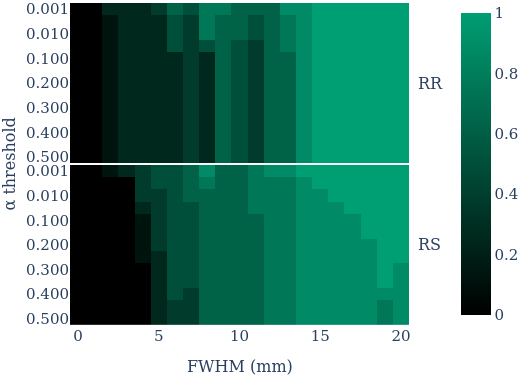

In [396]:
def plot_ieee_check(df):
    colormap = px.colors.make_colorscale(["black", "#009E73"])
    fig = px.imshow(
        df.T,
        facet_col_wrap=1,
        facet_col_spacing=0,
        facet_row_spacing=0,
        facet_col="reference_perturbation",
        color_continuous_scale=colormap,
        aspect="auto",
        labels={
            "x": "FWHM (mm)",
            "y": "α threshold",
            "value": "Ratio of successful tests",
        },
    )
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].upper()))
    fig.update_layout(
        width=525,
        height=375,
        title={
            "text": "FWHM (mm)",
            "xanchor": "center",
            "x": 0.5,
            "font_size": 20,
        },
        margin=dict(l=60, r=40, t=50, b=50),
        font_family="Serif",
        font=dict(size=15)
    )
    fig.update_annotations(text="")
    return fig

def plot_ieee_check(df):
    colormap = px.colors.make_colorscale(["black", "#009E73"])

    rr = df[df["reference_perturbation"] == "rr"]
    rs = df[df["reference_perturbation"] == "rs"]

    row_titles = ["RR", "RS"]

    alpha = df["alpha"].unique()
    alpha.sort()
    alpha = np.flip(alpha)

    x = list(map(str, df["reference_fwhm"].unique()))
    y = [f"{alpha:.3f}" for alpha in alpha]


    fig = make_subplots(rows=2, 
                        cols=1,
                        shared_xaxes=True,
                        shared_yaxes=True, 
                        row_titles=row_titles,
                        x_title="FWHM (mm)",
                        y_title="α threshold",
                        vertical_spacing=0.005, 
                        horizontal_spacing=0.005)
    
    z=rr.pivot(columns="reference_fwhm", index="alpha", values=0).to_numpy()
    fig.add_trace(
        go.Heatmap(
            z=np.flip(z, axis=0),
            x=x,
            y=y,
            colorscale=colormap,
            zmin=0,
            zmax=1,
            showscale=False,
        ),
        row=1,
        col=1,
    )
    z=rs.pivot(columns="reference_fwhm", index="alpha", values=0).to_numpy()
    fig.add_trace(
        go.Heatmap(
            z=np.flip(z, axis=0),
            x=x,
            y=y,
            colorscale=colormap,
            zmin=0,
            zmax=1,
            showscale=True,
        ),
        row=2,
        col=1,
    )
    rotate_row_titles(fig, row_titles)
    fig.update_layout(width=525, height=375, 
                      margin=dict(l=70, r=0, t=0, b=50), 
                      font_family="Serif", font=dict(size=15))
    fig.update_xaxes(nticks=5)
    fig.update_traces(colorbar_x=1.1, selector=dict(type='heatmap'))
    fig.write_image("within-subjects_bonferroni.png", scale=4)
    fig.update_annotations(xshift=-50, selector=lambda a: a.text == "α threshold")
    return fig

fig = plot_ieee_check(ieee_ratio_success)
if dynamic_figure:
    img = fig.show()
else:
    img = Image(fig.to_image(format="png"))
img

### Figure 5: Ratios of successful stability tests for the within- subject IEEE check. The between-subject IEEE check (not displayed in the figure) successfully rejected data computed from different subjects for all α and FWHM combinations, demonstrating excellent sensitivity.

In [397]:
template_pickles = os.path.join(stability_test_results, "templates", "*.pkl")
template_experiments = glob.glob(template_pickles, recursive=True)
template_df = load_pickle_files(template_experiments)
template_df.groupby(
    [
        "reference_version",
        "reference_dataset",
        "reference_subject",
        "reference_perturbation",
        "reference_template",
        "reference_fwhm",
        "target_dataset",
        "target_subject",
        "target_template",
        "confidence",
    ],
    group_keys=True,
).apply(lambda x: x, include_groups=False)
template_bonferroni = template_df[template_df["method"] == "fwe-bonferroni"].copy()
# For Bonferroni correction, a test passes if the number of rejected voxels is 0
template_bonferroni.loc[:, "pass"] = template_bonferroni["reject"] < 1
template_bonferroni.loc[:, "alpha"] = 1 - template_bonferroni["confidence"]
template_bonferroni = pd.merge(
    template_bonferroni,
    subjects_table[["Index", "Dataset", "Subject"]],
    left_on="target_subject",
    right_on="Subject",
)

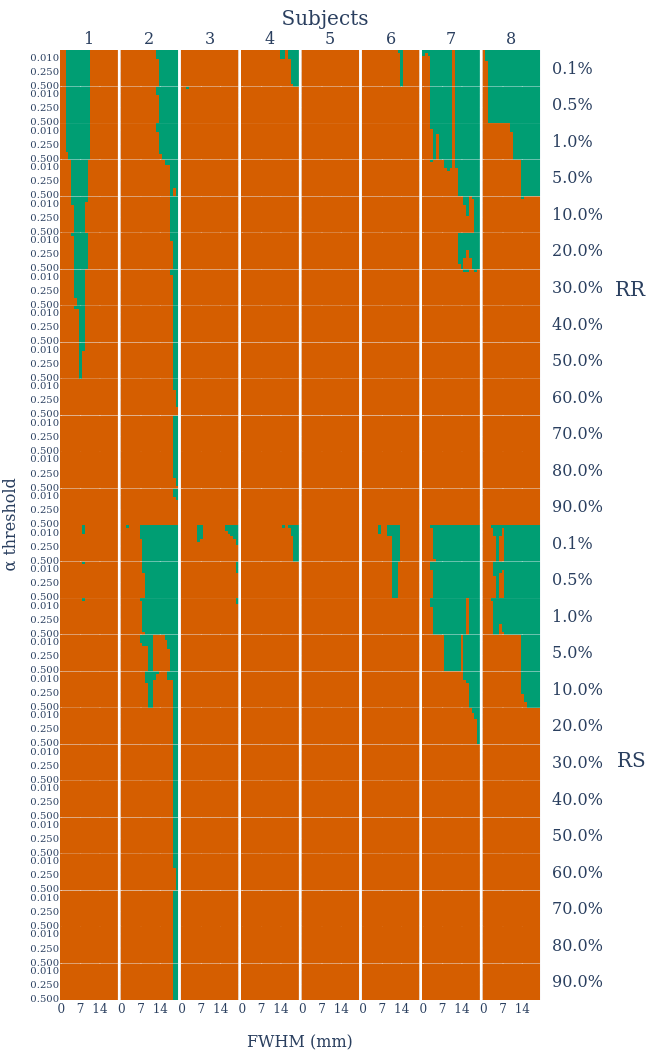

In [398]:
def extract_noise_level(template):
    # Extract noise level from MNI152NLin2009cAsymNoised0001
    noise = int(template.split("Noised")[1])
    return f"{noise / 10:.1f}%"


def rotate_row_titles(fig, row_titles):
    for annotation in fig["layout"]["annotations"]:
        if annotation["text"] in row_titles:
            annotation["textangle"] = 0
            annotation["x"] = 1
            annotation["xref"] = "paper"
            annotation["xanchor"] = "left"
            annotation["yref"] = "paper"
            annotation["yanchor"] = "middle"


def plot_template(df):
    rr = df[df["reference_perturbation"] == "rr"]
    rs = df[df["reference_perturbation"] == "rs"]

    templates = df["target_template"].unique()
    templates.sort()
    indexes = df["Index"].unique()
    indexes.sort()

    column_titles = list(map(str, indexes))
    row_titles = [extract_noise_level(template) for template in templates]

    fig = make_subplots(
        rows=2 * templates.size,
        cols=indexes.size,
        column_titles=column_titles,
        row_titles=2 * row_titles,
        shared_xaxes=True,
        shared_yaxes=True,
        x_title="FWHM (mm)",
        y_title="α threshold",
        vertical_spacing=0,
        horizontal_spacing=0.005,
    )
    alpha = df["alpha"].unique()
    alpha.sort()
    alpha = np.flip(alpha)

    x = list(map(str, df["reference_fwhm"].unique()))
    y = [f"{alpha:.3f}" for alpha in alpha]

    # Plot RR
    for i, template in enumerate(templates, start=1):
        for j, index in enumerate(indexes, start=1):
            data = rr[(rr["target_template"] == template) & (rr["Index"] == index)]
            z=data.pivot(index="reference_fwhm", columns="alpha", values="pass").to_numpy().astype(int).T
            fig.add_trace(
                go.Heatmap(
                    z=np.flip(z, axis=0),
                    x=x,
                    y=y,
                    colorscale=colorblind_palette,
                    zmin=0,
                    zmax=1,
                    showscale=False,
                ),
                row=i,
                col=j,
            )

    # Plot RS
    for i, template in enumerate(templates, start=1):
        for j, index in enumerate(indexes, start=1):
            data = rs[(rs["target_template"] == template) & (rs["Index"] == index)]
            z=data.pivot(index="reference_fwhm", columns="alpha", values="pass").to_numpy().astype(int).T
            fig.add_trace(
                go.Heatmap(
                    z=np.flip(z, axis=0),
                    x=x,
                    y=y,
                    colorscale=colorblind_palette,
                    zmin=0,
                    zmax=1,
                    showscale=False,
                ),
                row=i + templates.size,
                col=j,
            )

    fig.add_annotation(
        text="RR",
        x=1.2,
        y=0.763,
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=20,
    )
    fig.add_annotation(
        text="RS",
        x=1.2,
        y=0.238,
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=20,
    )

    fig.update_xaxes(tickangle=0, nticks=3)
    fig.update_yaxes(nticks=3, tickfont=dict(size=10))
    fig.update_layout(coloraxis_showscale=False)
    fig.update_traces(showlegend=False)
    fig.update_coloraxes(showscale=False)
    fig.update_layout(font_family="Serif", showlegend=False)
    rotate_row_titles(fig, row_titles)
    fig.update_layout(
        width=650,
        height=1050,
        title={
            "text": "Subjects",
            "xanchor": "center",
            "x": 0.5,
            "font_size": 20,
        },
        margin=(dict(l=60, r=100, t=50, b=50)),
    )

    fig.write_image("template_bonferroni.png", scale=4)
    return fig


fig = plot_template(template_bonferroni)
if dynamic_figure:
    img = fig.show()
else:
    img = Image(fig.to_image(format="png"))
img



### Figure 6: Corrupted template check for RR (top) and RS (bottom) modes. The stability tests correctly rejected results produced with corrupted templates beyond a subject-dependent threshold of corrupted voxels.

In [399]:
version_pickles = os.path.join(stability_test_results, "versions", "*.pkl")
version_experiments = glob.glob(version_pickles, recursive=True)
version_df = load_pickle_files(version_experiments)
version_df.groupby(
    [
        "reference_version",
        "reference_dataset",
        "reference_subject",
        "reference_perturbation",
        "reference_template",
        "reference_fwhm",
        "target_dataset",
        "target_subject",
        "target_template",
        "confidence",
    ],
    group_keys=True,
).apply(lambda x: x, include_groups=False)
version_bonferroni = version_df[version_df["method"] == "fwe-bonferroni"].copy()
# For Bonferroni correction, a test passes if the number of rejected voxels is 0
version_bonferroni.loc[:, "pass"] = version_bonferroni["reject"] < 1
version_bonferroni.loc[:, "alpha"] = 1 - version_bonferroni["confidence"]
version_bonferroni = pd.merge(
    version_bonferroni,
    subjects_table[["Index", "Dataset", "Subject"]],
    left_on="target_subject",
    right_on="Subject",
)

In [400]:
def rotate_row_titles(fig, row_titles):
    for annotation in fig["layout"]["annotations"]:
        if annotation["text"] in row_titles:
            annotation["textangle"] = 0
            annotation["x"] = 1
            annotation["xref"] = "paper"
            annotation["xanchor"] = "left"
            annotation["yref"] = "paper"
            annotation["yanchor"] = "middle"

def plot_version(df):
    rr = df[df["reference_perturbation"] == "rr"]
    rs = df[df["reference_perturbation"] == "rs"]

    versions = df["target_version"].unique()
    versions.sort()
    indexes = df["Index"].unique()
    indexes.sort()

    column_titles = list(map(str, indexes))
    row_titles = versions.tolist()

    fig = make_subplots(
        rows=2 * versions.size,
        cols=indexes.size,
        column_titles=column_titles,
        row_titles=2 * row_titles,
        shared_xaxes=True,
        shared_yaxes=True,
        x_title="FWHM (mm)",
        y_title="α threshold",
        vertical_spacing=0,
        horizontal_spacing=0.005,
    )
    alpha = df["alpha"].unique()
    alpha.sort()
    alpha = np.flip(alpha)

    x = list(map(str, df["reference_fwhm"].unique()))
    y = [f"{alpha:.3f}" for alpha in alpha]

    # Plot RR
    for i, version in enumerate(versions, start=1):
        for j, index in enumerate(indexes, start=1):
            data = rr[(rr["target_version"] == version) & (rr["Index"] == index)]
            z=data.pivot(index="reference_fwhm", columns="alpha", values="pass").to_numpy().astype(int).T
            fig.add_trace(
                go.Heatmap(
                    z=np.flip(z, axis=0),
                    x=x,
                    y=y,
                    colorscale=colorblind_palette,
                    zmin=0,
                    zmax=1,
                    showscale=False,
                ),
                row=i,
                col=j,
            )

    # Plot RS
    for i, version in enumerate(versions, start=1):
        for j, index in enumerate(indexes, start=1):
            data = rs[(rs["target_version"] == version) & (rs["Index"] == index)]
            z=data.pivot(index="reference_fwhm", columns="alpha", values="pass").to_numpy().astype(int).T
            fig.add_trace(
                go.Heatmap(
                    z=np.flip(z, axis=0),
                    x=x,
                    y=y,
                    colorscale=colorblind_palette,
                    zmin=0,
                    zmax=1,
                    showscale=False,
                    zsmooth=None
                ),
                row=i + versions.size,
                col=j,
            )

    fig.update_xaxes(tickangle=0)
    fig.update_xaxes(automargin=True)
    fig.update_xaxes(nticks=3) 
    fig.update_yaxes(nticks=3) 
    fig.update_layout(coloraxis_showscale=False)
    fig.update_traces(showlegend=False)
    fig.update_coloraxes(showscale=False)
    fig.update_layout(font_family="Serif", showlegend=False)
    rotate_row_titles(fig, row_titles)
    fig.update_layout(
        width=600,
        height=1050,
        title={
            "text": "Subjects",
            "xanchor": "center",
            "x": 0.5,
            "font_size": 20,
        },
    )

    fig.write_image("version_bonferroni.png", scale=4)
    return fig


fig = plot_version(version_bonferroni)
if dynamic_figure:
    fig.show()
else:
    Image(fig.to_image(format="png"))

### Figure 7: Application of the stability test across fMRIPrep versions, with the reference distribution constructed using version 20.2.1. The test indicated a divergence in the results beginning with version 20.2.5. Investigations showed a sub- stantial change in the fMRIPrep analysis methods since version 20.2.5, correctly detected by the stability test.

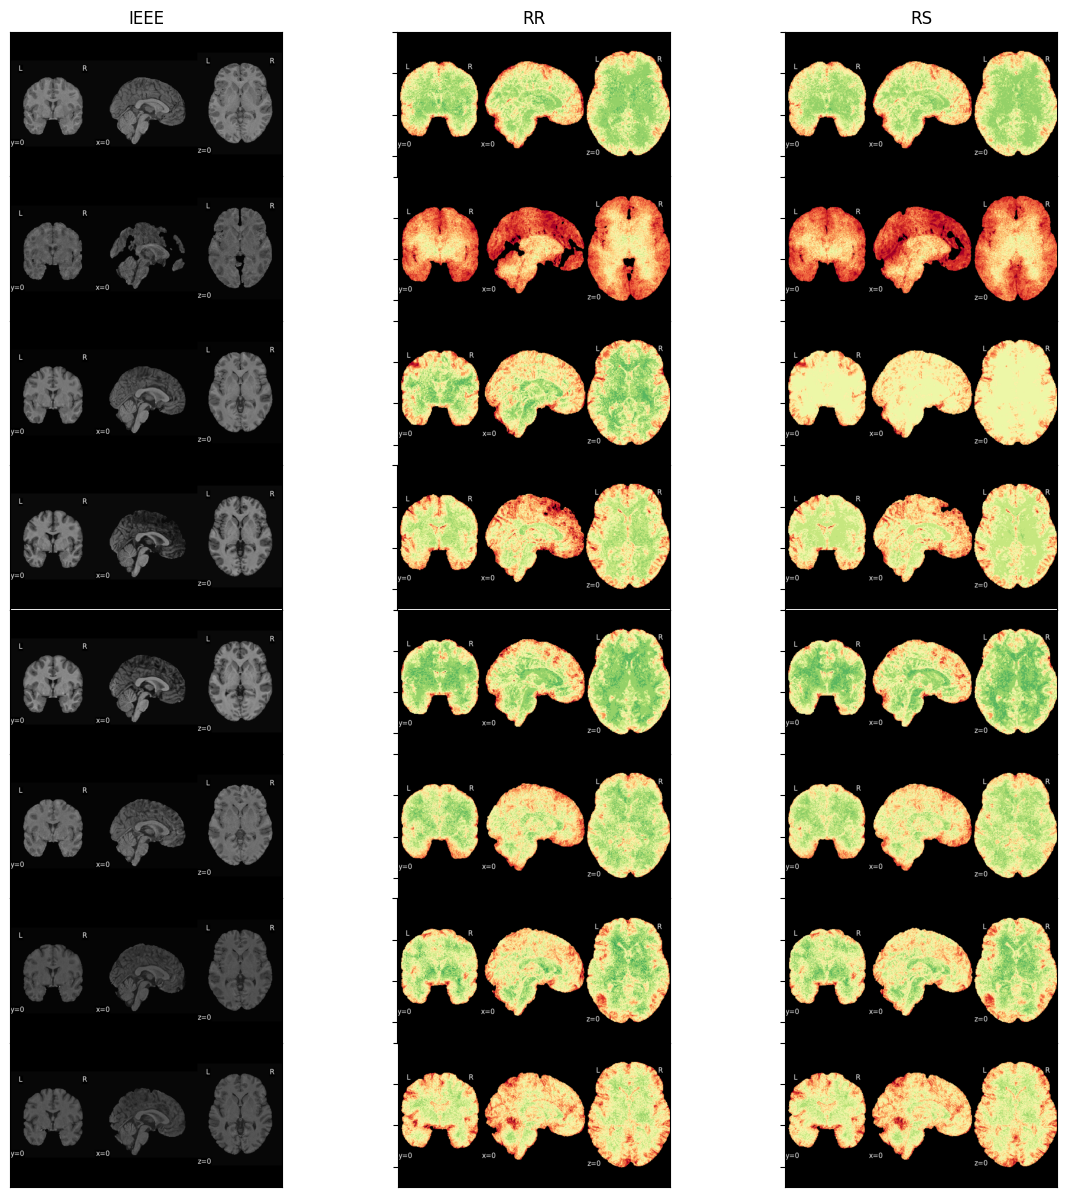

In [401]:
create_grid_numerical_variability(normalized=False, fwhm=0)

## Figure 8: Numerical variability measured for subjects 1 to 8 (from top to bottom) across n=30 perturbed samples, with FWHM=0mm. 

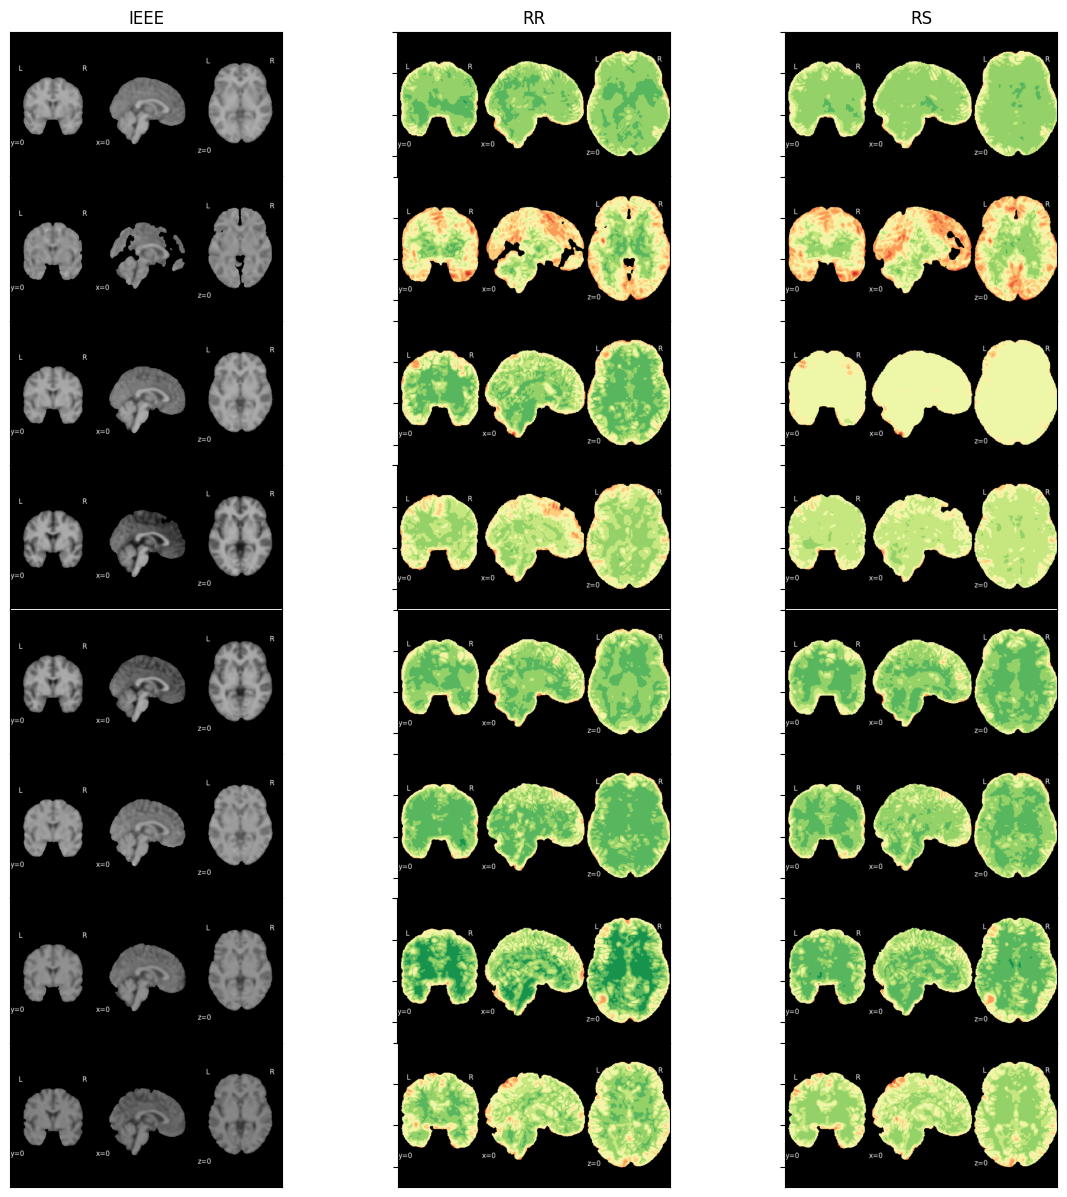

In [402]:
create_grid_numerical_variability(normalized=False, fwhm=5)

## Figure 9: Numerical variability measured for subjects 1 to 8 (from top to bottom) across n=30 perturbed samples, with FWHM=5mm. 

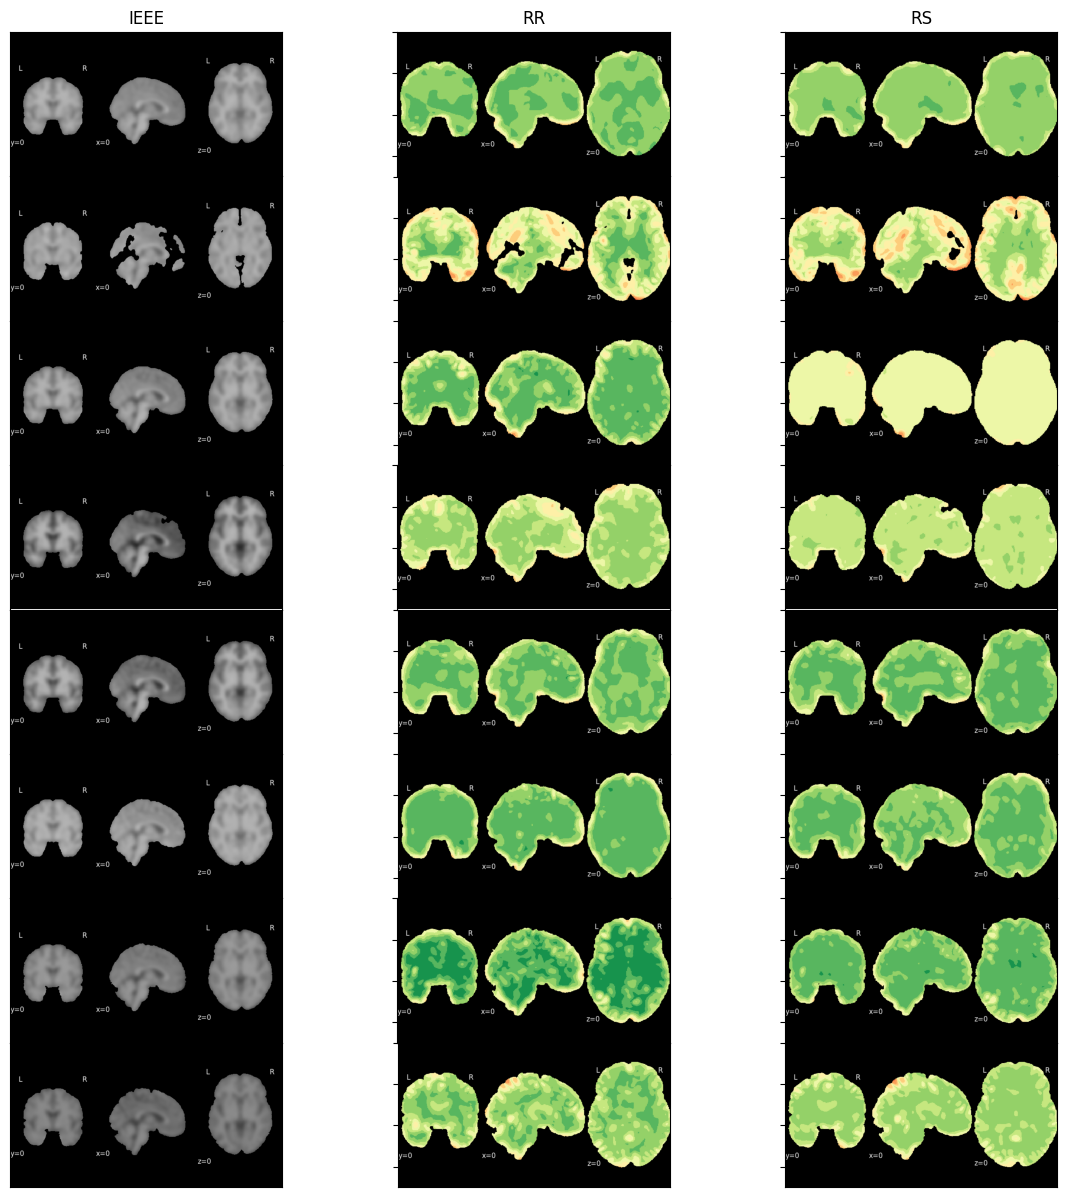

In [403]:
create_grid_numerical_variability(normalized=False, fwhm=10)

## Figure 10: Numerical variability measured for subjects 1 to 8 (from top to bottom) across n=30 perturbed samples, with FWHM=10mm. 

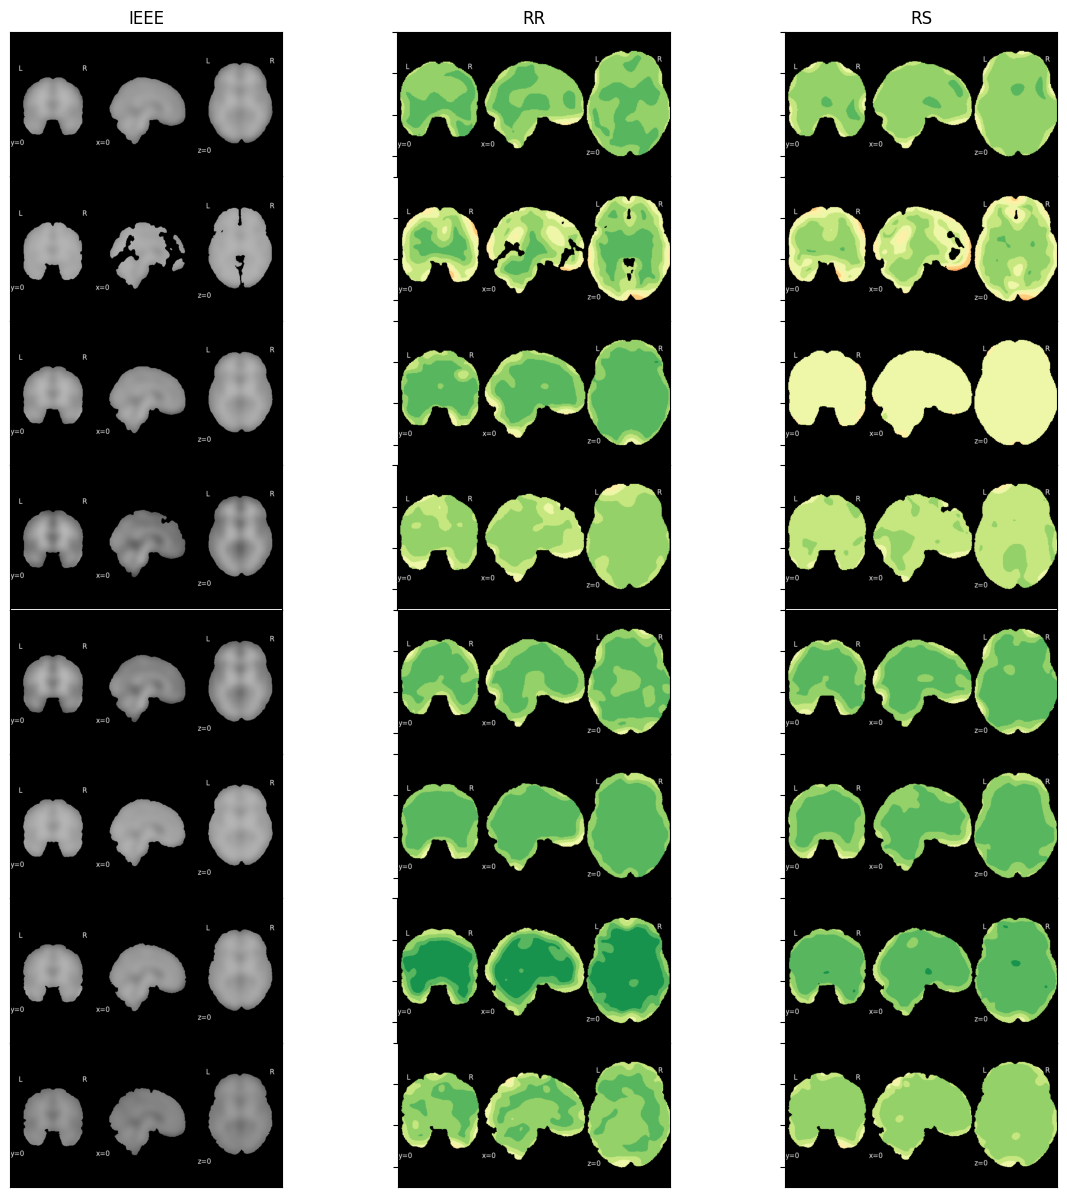

In [404]:
create_grid_numerical_variability(normalized=False, fwhm=20)

## Figure 11: Numerical variability measured for subjects 1 to 8 (from top to bottom) across n=30 perturbed samples, with FWHM=20mm. 